In [1]:
import pandas as pd
import glob, sys, os
import json, torch, random
import numpy as np
sys.path.append("../")
import utilities as utl
from sentence_transformers import SentenceTransformer
from pympler import asizeof
from sklearn.cluster import KMeans, AgglomerativeClustering
from bkmeans import BKMeans
from sklearn.metrics import pairwise_distances
import div_utilities as div_utl
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def plot_grouped_barchart(dataframe, algorithm_col, time_col, query_col, annotate_values = False, annotate_query_tables = False):
    """
    Plot a grouped bar chart with queries on the X-axis, time on the Y-axis, and each group containing bars for different algorithms.

    Parameters:
    - dataframe: Pandas DataFrame containing the data.
    - algorithm_col: Name of the column containing algorithm names.
    - time_col: Name of the column containing time values.
    - query_col: Name of the column containing query names.
    """
    predefined_order = [r'$GMC$', r'$GNE$',r'$CLT$',r'$DUST$']
    
    # Get unique algorithms and queries
    unique_algorithms = dataframe[algorithm_col].unique()
    # print(unique_algorithms)
    unique_queries = dataframe[query_col].unique()
    sorted_indices = np.argsort(unique_queries)
    unique_queries = unique_queries[sorted_indices]
    # unique_algorithms = sorted(unique_algorithms, key=lambda x: predefined_order.index(x) if x in predefined_order else float('inf'))

    # Set up positions for bars on X-axis
    bar_width = 0.22 # Adjust the width as needed
    # space_between_groups = 0.5
    bar_positions = np.arange(len(unique_queries))

    # # Define a color blindness-friendly palette with hatch patterns
    #palette = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#a6cee3', '#b2df8a', '#fb9a99']

    # Hatch patterns for bars
    #hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', '*']
    
    if len(unique_queries) == 3:
        palette = ['#1f78b4', '#e31a1c', '#ff7f00']
        # Hatch patterns for bars
        hatch_patterns = ['/', '+', 'o']
    else:
        # Define a color blindness-friendly palette with hatch patterns
        palette = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#a6cee3']
        hatch_patterns = ['/', '\\', '+', 'o', "*", "-"]

    # Create a grouped bar chart
    plt.figure(figsize=(19, 6))  # Adjust the figure size as needed

    for i, algorithm in enumerate(unique_algorithms):
        algorithm_data = dataframe[dataframe[algorithm_col] == algorithm]
        mean_times = [algorithm_data[algorithm_data[query_col] == query][time_col].mean() for query in unique_queries]
        print("Algorithm time: ", mean_times)
        hatch_pattern = hatch_patterns[i % len(hatch_patterns)]
        plt.bar(
            bar_positions + i * (bar_width),
            mean_times,
            width=bar_width,
            label=algorithm,
            color=palette[i],
            hatch=hatch_pattern,
            edgecolor='black'  # Add black borders for better visibility
        )
    if annotate_values == True:
        # Annotate each bar in the group
        for i, query in enumerate(unique_queries):
            for j, algorithm in enumerate(unique_algorithms):
                mean_time = dataframe[(dataframe[algorithm_col] == algorithm) & (dataframe[query_col] == query)][time_col].mean()
                plt.text(bar_positions[i] + j * bar_width, mean_time + 0.02, f'{round(mean_time)}', ha='center', va='bottom')
    # Add labels and title
    
        # Set X-axis ticks and labels
    # plt.xticks(bar_positions + (len(unique_algorithms) - 1) * bar_width / 2, unique_queries)
    plt.xlim(bar_positions[0] - bar_width / 2 - 0.3, bar_positions[-1] + (len(unique_algorithms) - 0.5) * bar_width + 0.3)

    if annotate_query_tables:
        # Add labels below each group of bars
        for i, query in enumerate(unique_queries):
            plt.text((bar_positions + (len(unique_algorithms) - 1) * bar_width / 2)[i], -0.00012,
                    f'{query[:15].strip()}...', rotation=70, ha='right', va='top')
    # Add legend
    plt.legend() #(loc = "upper right")
    return plt
        # # Show the plot
        # plt.show()

In [3]:
benchmark_name = 'ugen_benchmark'
folder_path = r'final_stats'

In [5]:
# starmie_df = pd.read_csv(f"{folder_path}/{benchmark_name}__cosine__dust__filtered_file.csv")
# llm_df = pd.read_csv(f"{folder_path}/{benchmark_name}__cosine__dust.csv")
dust_df = pd.read_csv(f"{folder_path}/{benchmark_name}__cosine__dust__our.csv")
random_df = pd.read_csv(f"{folder_path}/{benchmark_name}__cosine__dust__random.csv")

In [6]:
# result_dataframe = starmie_df
result_dataframe =dust_df
# result_dataframe = pd.concat([result_dataframe, llm_df])
result_dataframe = pd.concat([result_dataframe, dust_df])
result_dataframe = pd.concat([result_dataframe, random_df])


In [7]:
result_dataframe.drop_duplicates(inplace=True)

In [8]:
result_dataframe

,algorithm,query_name,|S|,|q|,k,algorithm_distance_function,evaluation_distance_function,with_query_flag,normalized,max_div_score,max-min_div_score,avg_div_score,time_taken_(s),embedding_type
0,our,Anthropology_FGTNBDWF.csv,79,7,30,cosine,cosine,yes,True,NaN,0.000236,0.131437,0.35,dust
1,our,Anthropology_FGTNBDWF.csv,79,7,30,cosine,cosine,no,True,NaN,0.001149,0.113728,0.35,dust
2,our,Anthropology_FGTNBDWF.csv,79,7,30,cosine,cosine,mix,True,NaN,0.001149,0.130777,0.35,dust
3,our,Archeology_2LWSQ5A2.csv,81,5,30,cosine,cosine,yes,True,NaN,0.002011,0.198839,0.35,dust
4,our,Archeology_2LWSQ5A2.csv,81,5,30,cosine,cosine,no,True,NaN,0.002011,0.179874,0.35,dust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,random,Veterinary Science_69LHVLEQ.csv,54,4,30,cosine,cosine,no,True,NaN,0.000122,0.060290,0.00,dust
128,random,Veterinary Science_69LHVLEQ.csv,54,4,30,cosine,cosine,mix,True,NaN,0.000122,0.082658,0.00,dust
129,random,World Geography_8JTGEV49.csv,52,4,30,cosine,cosine,yes,True,NaN,0.000018,0.238743,0.00,dust
130,random,World Geography_8JTGEV49.csv,52,4,30,cosine,cosine,no,True,NaN,0.000018,0.211251,0.00,dust


In [21]:
result_dataframe['algorithm'] = result_dataframe['algorithm'].replace({'gmc': r'$GMC$', 'gne': r'$GNE$', "clt": r'$CLT$', "our": r'$DUST$', "our_base": r'$DUST_{c}$', "Starmie": r'$Starmie$', "LLM": r"$LLM$", "random": r'$Random$',})
exclude_algs = {r"$DUST_{c}$", r'$GMC$', r'$CLT$',r'$GNE$', r"$CLT$", r"$Starmie$", r"$LLM$"}
distance_function = "cosine"
with_query_flag = "mix"
metric = "max-min_div_score" 
# metric = "avg_div_score"

In [22]:
result_dataframe

,algorithm,query_name,|S|,|q|,k,algorithm_distance_function,evaluation_distance_function,with_query_flag,normalized,max_div_score,max-min_div_score,avg_div_score,time_taken_(s),embedding_type
0,$DUST$,Anthropology_FGTNBDWF.csv,79,7,30,cosine,cosine,yes,True,NaN,0.000236,0.131437,0.35,dust
1,$DUST$,Anthropology_FGTNBDWF.csv,79,7,30,cosine,cosine,no,True,NaN,0.001149,0.113728,0.35,dust
2,$DUST$,Anthropology_FGTNBDWF.csv,79,7,30,cosine,cosine,mix,True,NaN,0.001149,0.130777,0.35,dust
3,$DUST$,Archeology_2LWSQ5A2.csv,81,5,30,cosine,cosine,yes,True,NaN,0.002011,0.198839,0.35,dust
4,$DUST$,Archeology_2LWSQ5A2.csv,81,5,30,cosine,cosine,no,True,NaN,0.002011,0.179874,0.35,dust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,$Random$,Veterinary Science_69LHVLEQ.csv,54,4,30,cosine,cosine,no,True,NaN,0.000122,0.060290,0.00,dust
128,$Random$,Veterinary Science_69LHVLEQ.csv,54,4,30,cosine,cosine,mix,True,NaN,0.000122,0.082658,0.00,dust
129,$Random$,World Geography_8JTGEV49.csv,52,4,30,cosine,cosine,yes,True,NaN,0.000018,0.238743,0.00,dust
130,$Random$,World Geography_8JTGEV49.csv,52,4,30,cosine,cosine,no,True,NaN,0.000018,0.211251,0.00,dust


In [23]:
set(result_dataframe['algorithm'])

{'$DUST$', '$Random$'}

In [24]:
# selected_columns_df = result_dataframe[['algorithm', 'query_name', 'time_taken_(s)']]
# # Drop duplicates, if any
# selected_columns_df['query_name'] = "All Labeled Queries" 
# selected_columns_df = selected_columns_df.drop_duplicates()
# # Display the resulting DataFrame
# print(selected_columns_df)
# plt = plot_grouped_barchart(selected_columns_df, 'algorithm', 'time_taken_(s)', 'query_name', annotate_values=True)
# #plt.ylim(0, 50, 5)
# #plt.yscale("log")
# plt.xlabel('Query')
# plt.ylabel('Time Taken (s)')
# plt.title('Time Taken by Algorithm for Different Queries')
# plt.tight_layout()


In [25]:
# Select rows where 'with_query_flag' is 'yes' and 'evaluation_distance_function' is 'cosine'

subset_df = result_dataframe[(result_dataframe['with_query_flag'] == with_query_flag) & 
                                (result_dataframe['evaluation_distance_function'] == distance_function) & (result_dataframe['algorithm_distance_function'] == distance_function) & (~result_dataframe['algorithm'].isin(exclude_algs))].drop_duplicates()

In [26]:
subset_df

,algorithm,query_name,|S|,|q|,k,algorithm_distance_function,evaluation_distance_function,with_query_flag,normalized,max_div_score,max-min_div_score,avg_div_score,time_taken_(s),embedding_type
2,$DUST$,Anthropology_FGTNBDWF.csv,79,7,30,cosine,cosine,mix,True,NaN,0.001149,0.130777,0.35,dust
5,$DUST$,Archeology_2LWSQ5A2.csv,81,5,30,cosine,cosine,mix,True,NaN,0.002011,0.200589,0.35,dust
8,$DUST$,Architecture_LMDVYEG9.csv,89,4,30,cosine,cosine,mix,True,NaN,0.001529,0.141196,0.37,dust
11,$DUST$,Art History_XEJNANHA.csv,30,3,30,cosine,cosine,mix,True,NaN,0.000529,0.088046,0.16,dust
14,$DUST$,Astronautics_ISIRDAPX.csv,75,4,30,cosine,cosine,mix,True,NaN,0.000840,0.094468,0.34,dust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,$Random$,Sports_XNQ2V548.csv,85,5,30,cosine,cosine,mix,True,NaN,0.000053,0.063494,0.00,dust
122,$Random$,Technology_T7S94C89.csv,137,8,30,cosine,cosine,mix,True,NaN,0.000016,0.132177,0.00,dust
125,$Random$,Veterinary Medicine_5MKZDV7M.csv,83,9,30,cosine,cosine,mix,True,NaN,0.000157,0.042552,0.00,dust
128,$Random$,Veterinary Science_69LHVLEQ.csv,54,4,30,cosine,cosine,mix,True,NaN,0.000122,0.082658,0.00,dust


Algorithm time:  [0.0011487007141113, 0.0020108520984649, 0.0015287995338439, 0.0005285739898681, 0.0008399188518524, 0.002163678407669, 0.0001969337463378, 0.0006120800971984, 0.0014652609825134, 0.0013956129550933, 0.0008456408977508, 0.00021493434906, 0.0014355182647705, 0.0016499459743499, 0.0014007091522216, 0.0001097023487091, 0.002002865076065, 0.0027268528938293, 0.0011090338230133, 0.0015395283699035, 0.0013031661510467, 0.000547856092453, 0.0014165341854095, 0.0005031526088714, 0.0019465386867523, 0.0017240047454833, 0.0020333230495452, 0.0028750002384185, 0.0007224082946777, 0.0026171207427978, 0.0003415346145629, 0.0014906525611877, 0.0013679265975952, 0.0039376318454742, 0.0007425546646118, 4.032254219055176e-05, 0.0005960762500762, 0.0004909038543701, 0.0021323859691619, 0.001245766878128, 0.0004994869232177, 0.0001885890960693, 0.0017016530036926, 0.0019601285457611, 0.0022765696048736, 0.0008768737316131, 0.0002330243587493, 0.000806450843811]
Algorithm time:  [3.463029

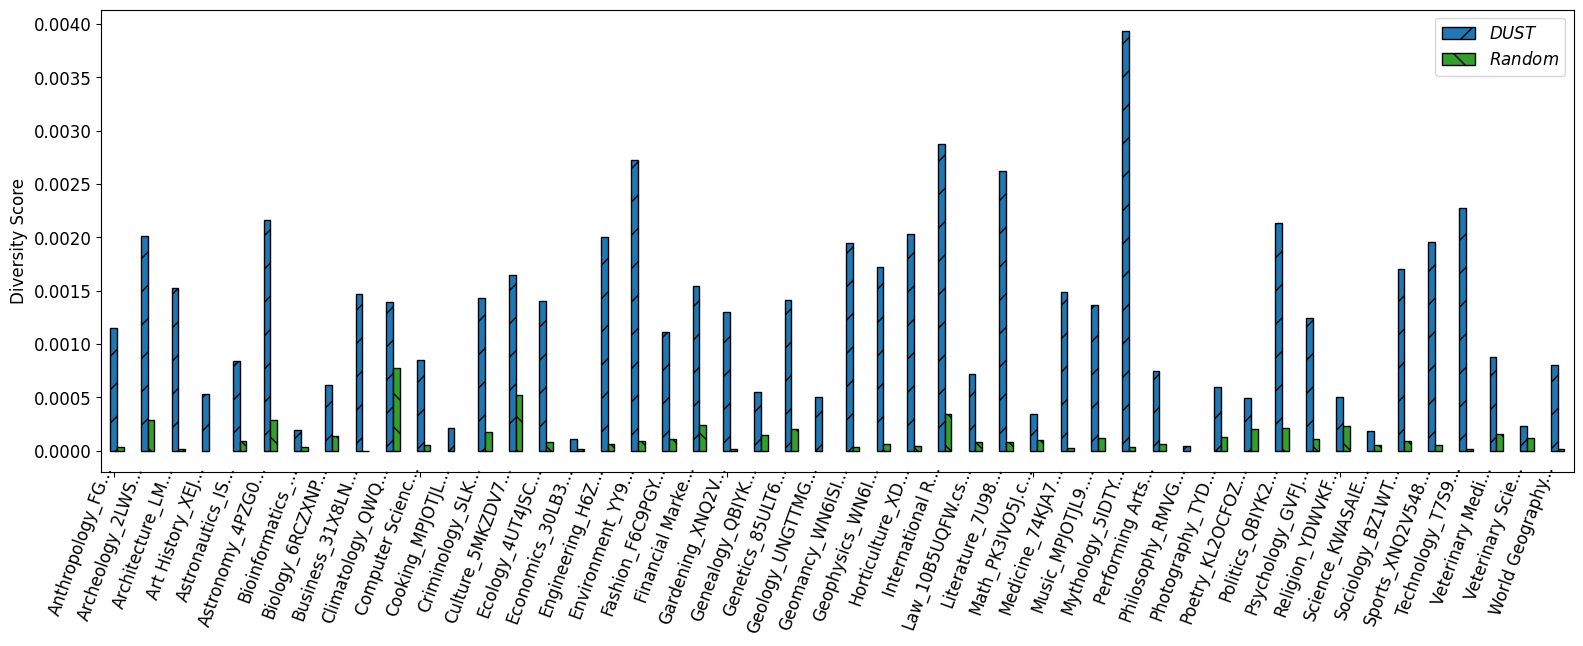

In [27]:
plt = plot_grouped_barchart(subset_df, 'algorithm', metric, 'query_name', annotate_query_tables= True)
#plt.ylim(0,1)
#plt.xlabel('Query')
plt.rcParams.update({'font.size': 12})
plt.tick_params(labelbottom = False)

plt.ylabel('Diversity Score')
plt_name = "santos_avg_diversity_cosine"
#plt.title(f'{metric} using {distance_function.upper()} distance in {benchmark_name.replace("_", " ")}')
#plt.title(f'Max-min Diversity Score using Cosine distance in UGEN-V1 Benchmark')
# plt.savefig(f"div_plots/paper_plots/{plt_name}.pdf", format='pdf', bbox_inches='tight')

In [28]:
highest_count = {}
for idx, rows in subset_df.iterrows():
    alg = rows["algorithm"]
    query = rows["query_name"]
    div_score = rows[metric]
    if query not in highest_count:
        highest_count[query] = {alg: div_score}
    else:
        current_counts = highest_count[query]
        if alg in current_counts:
            print("oops")
        else:
            current_counts[alg] = div_score
        highest_count[query] = current_counts

In [29]:
highest_count = {key: value for key, value in highest_count.items() if len(value) >= 2}
highest_count

{'Anthropology_FGTNBDWF.csv': {'$DUST$': 0.0011487007141113,
  '$Random$': 3.463029861450195e-05},
 'Archeology_2LWSQ5A2.csv': {'$DUST$': 0.0020108520984649,
  '$Random$': 0.0002879500389099},
 'Architecture_LMDVYEG9.csv': {'$DUST$': 0.0015287995338439,
  '$Random$': 1.913309097290039e-05},
 'Astronautics_ISIRDAPX.csv': {'$DUST$': 0.0008399188518524,
  '$Random$': 8.577108383178711e-05},
 'Astronomy_4PZG0DSK.csv': {'$DUST$': 0.002163678407669,
  '$Random$': 0.000288188457489},
 'Bioinformatics_YSAIJRVV.csv': {'$DUST$': 0.0001969337463378,
  '$Random$': 3.2901763916015625e-05},
 'Biology_6RCZXNPM.csv': {'$DUST$': 0.0006120800971984,
  '$Random$': 0.0001401901245117},
 'Business_31X8LNYS.csv': {'$DUST$': 0.0014652609825134,
  '$Random$': -5.960464477539064e-08},
 'Climatology_QWQ27CT2.csv': {'$DUST$': 0.0013956129550933,
  '$Random$': 0.0007711350917816},
 'Computer Science_WN6ISIGQ.csv': {'$DUST$': 0.0008456408977508,
  '$Random$': 5.27501106262207e-05},
 'Criminology_SLK5C5T9.csv': {'$

In [30]:
print(len(highest_count))

44


In [31]:
max_keys = list({outer_key: max(inner_dict, key=inner_dict.get) for outer_key, inner_dict in highest_count.items()}.values())

In [32]:
print(Counter(max_keys))

Counter({'$DUST$': 44})


In [ ]:
max_keys

In [ ]:
best_counts = {}
second_best_counts = {}

for table, methods in highest_count.items():
    best_method = max(methods, key=methods.get)
    sorted_methods = sorted(methods, key=methods.get, reverse=True)
    second_best = sorted_methods[1]  # Second highest score, as the list is sorted in descending order

    if best_method not in best_counts:
        best_counts[best_method] = 1
    else:
        best_counts[best_method] += 1

    if best_method not in second_best_counts:
        second_best_counts[best_method] = {}

    if second_best not in second_best_counts[best_method]:
        second_best_counts[best_method][second_best] = 1
    else:
        second_best_counts[best_method][second_best] += 1

print("Best method counts for each table:", best_counts)
print("Second best method counts for each best method:", second_best_counts)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load CSV data into a DataFrame
x_axis = "s"
df = pd.read_csv(f'div_stats/efficiency_benchmark_{x_axis}_vs_time_cosine__dust.csv')
df['algorithm'] = df['algorithm'].replace({'gmc': r'$GMC$', 'gne': r'$GNE$', "clt": r'$CLT$', "our": r'$DUST$', "our_base": r'$DUST_{c}$'})
# Create a figure and axis
fig, ax = plt.subplots()

# Define a list of color-blind-friendly line styles and markers
line_styles = ['-', '--', '-.', ':']
markers = ['o', '^', 's', 'D']
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green']

# Create a dictionary to map algorithms to line styles and markers
algorithm_styles = {}
for i, algorithm in enumerate(df['algorithm'].unique()):
    algorithm_styles[algorithm] = {'line_style': line_styles[i % len(line_styles)],
                                   'marker': markers[i % len(markers)], 'color': colors[i % len(colors)]}
if x_axis == "s":
    x_axis = "|S|"
# Iterate over unique algorithms in the DataFrame and plot each one
for algorithm in df['algorithm'].unique():
    algorithm_data = df[df['algorithm'] == algorithm]
    style = algorithm_styles[algorithm]
    ax.plot(algorithm_data[x_axis], algorithm_data['time_taken_(s)'], label=algorithm, linestyle=style['line_style'], marker=style['marker'], color=style['color'])

if x_axis == "|S|":
    x_axis = "s"
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}K'.format(x / 1000) if x >= 1000 else '{:.1f}'.format(x)))
    ax.set_xlabel('Number of input unionable tuples (s)')
else:
    ax.set_xlabel('Number of output tuples (k)')

#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}K'.format(x / 1000) if x >= 1000 else '{:.1f}'.format(x)))
# Set labels and title

ax.set_ylabel('Runtime (seconds)')
# ax.set_title('Algorithm Performance Comparison')

# Display legend
#ax.legend()
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(df['algorithm'].unique()))
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt_name = f"diversity_{x_axis}_vs_time"
plt.savefig(f"div_plots/paper_plots/{plt_name}.pdf", format='pdf', bbox_inches='tight')
# Show the plot
#plt.show()


In [ ]:
df = pd.read_csv(r"/home/khatiwada/dust/diversity_algorithms/final_stats/labeled_benchmark__cosine__dust__ourunpruned.csv")
# df = pd.read_csv(r"/home/khatiwada/dust/diversity_algorithms/final_stats/labeled_benchmark__cosine__dust__filtered_file.csv")
filtered_df = df[df['algorithm'] == 'our']
average_time_taken = filtered_df['time_taken_(s)'].mean()
average_time_taken